# Submissions

In [1]:
from sklearn import datasets
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
import matplotlib.pyplot as plt
from __future__ import division
import pandas as pd
import numpy as np
import pickle
%matplotlib inline

#iris = datasets.load_iris()
#X, y = iris.data[:, 1:3], iris.target
df = pd.read_csv("Matchup_KP.csv")
features = ['FieldGoalAvg', 'ThreePointAvg', 'FreeThrowAvg', 'ReboundAvg', 'AssistAvg', 'TurnOverAvg', 
            'StealAvg', 'BlockAvg', 'PersonalFoulAvg', 'Pyth', 'Rank', 'AdjustO', 'AdjustO Rank', 'AdjustD', 
            'AdjustD Rank', 'AdjustT', 'AdjustT Rank', 'Luck', 'Luck Rank']
features2 = ['Pyth', 'Rank', 'AdjustO', 'AdjustO Rank', 'AdjustD', 
            'AdjustD Rank', 'AdjustT', 'AdjustT Rank', 'Luck', 'Luck Rank']
# Load Elo Ratings (dict)
team_elos = pickle.load(open("../elo/data/team_elos.p", "rb"))
# Extremely Random Forest Features
features3 = ['Pyth', 'AdjustO', 'AdjustD', 'Luck','FieldGoalAvg']
# Random Forest Features
features4 = ['Pyth', 'AdjustO', 'AdjustD', 'Luck','BlockAvg']
# Gradient Boosting Features
features5 = ['Pyth', 'AdjustO', 'Luck','BlockAvg','AssistAvg']
#ADA Boost
features6 = ['Pyth','Luck','AdjustO','AdjustD','FieldGoalAvg']

In [2]:
Submission = pd.read_csv("2016Submission.csv")
submission_test = Submission[features2]

X = df[features2]
y = df.WinLoss

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard', weights=None)

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_validation.cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

#Accuracy: 0.90 (+/- 0.05) [Logistic Regression]
#Accuracy: 0.93 (+/- 0.05) [Random Forest]
#Accuracy: 0.91 (+/- 0.04) [naive Bayes]
#Accuracy: 0.95 (+/- 0.05) [Ensemble]

Accuracy: 0.79 (+/- 0.03) [Logistic Regression]
Accuracy: 0.75 (+/- 0.04) [Random Forest]
Accuracy: 0.79 (+/- 0.03) [naive Bayes]
Accuracy: 0.79 (+/- 0.03) [Ensemble]


In [3]:
def fit_best_model(model, parameters):
    m = model()
    m = GridSearchCV(m, parameters)
    m.fit(X, y)
    return m.best_estimator_, m.best_params_

def fit_best_voting_model(model, parameters):
    m = model(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)])
    m = GridSearchCV(m, parameters)
    m.fit(X, y)
    return m.best_estimator_, m.best_params_

In [4]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Loss', 'Win'], rotation=45)
    plt.yticks(tick_marks, ['Loss', 'Win'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def accuracies(cm):
    totals = np.sum(cm, 1)
    no_acc = cm[0, 0] / totals[0]
    yes_acc = cm[1, 1] / totals[1]
    print("Loss Acc: {0}".format(no_acc))
    print("Win Acc: {0}".format(yes_acc))
    print("Avg Acc: {0}".format((no_acc + yes_acc)/2))
    

def run_model(model):
    clf = model
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    plot_confusion_matrix(cm)
    accuracies(cm)

In [5]:
def get_elo(season, team):
    try:
        return team_elos[season][team]
    except:
        try:
            # Get the previous season's ending value.
            team_elos[season][team] = team_elos[season-1][team]
            return team_elos[season][team]
        except:
            # Get the starter elo.
            team_elos[season][team] = base_elo
            return team_elos[season][team]
        
def get_elo_diff(team_1, team_2, season):
    elo1 = get_elo(season, team_1)
    elo2 = get_elo(season, team_2)
    return elo1 - elo2

In [6]:
def append_elos():
    dFrames = [df, Submission]
    for i, dFrame in enumerate(dFrames):
        elo_diffs = []
        for index, row in dFrame.iterrows():
            elo_diffs.append(get_elo_diff(row['Wteam'], row['Lteam'], row['Year']))
        elos = pd.DataFrame(elo_diffs, columns = ['Elo Rank'])
        if i==0:
            X_elos = pd.concat([X, elos], axis=1)
        else:
            submission_elos = pd.concat([submission_test, elos], axis=1)
    return X_elos, submission_elos

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Logistic Regression

('Logistic Regression Parameters:', {'penalty': 'l1', 'C': 0.019306977288832496, 'solver': 'liblinear'})
[[202  56]
 [ 59 236]]


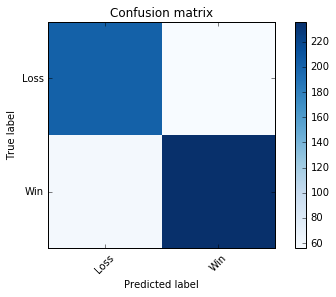

Loss Acc: 0.782945736434
Win Acc: 0.8
Avg Acc: 0.791472868217


In [8]:
param_clf1 = {'penalty':['l1', 'l2'], 'C':np.logspace(-4, 4, 8), 'solver':['liblinear']}
clf1, param_clf1 = fit_best_model(LogisticRegression, param_clf1)
print('Logistic Regression Parameters:', param_clf1)
run_model(clf1)

In [9]:
predictions = clf1.predict_proba(submission_test)
Submission.Pred = predictions[:,1]
LogisticRegressionSubmission = Submission[['Id','Pred']].sort_values(by = 'Id')
LogisticRegressionSubmission.to_csv("results1/submissionLR.csv",index = False)

# Random Forest

('Random Forest Parameters:', {'max_features': 'auto', 'n_estimators': 300})
[[191  67]
 [ 70 225]]


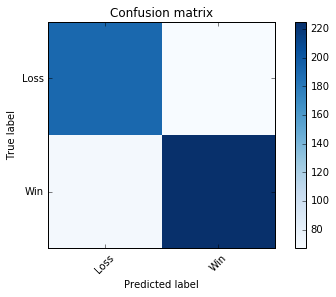

Loss Acc: 0.740310077519
Win Acc: 0.762711864407
Avg Acc: 0.751510970963


In [10]:
#p = {'n_estimators':[10, 50, 100, 300, 500, 1000,1500], 'max_features': [ None, 'auto', 'sqrt', 'log2']}
p = {'n_estimators':[10, 50, 100, 300, 500, 1000], 'max_features': [ None, 'auto', 'sqrt', 'log2']}
clf2, param_clf2 = fit_best_model(RandomForestClassifier, p)

print('Random Forest Parameters:', param_clf2)
run_model(clf2)

In [11]:
predictions = clf2.predict_proba(submission_test)
Submission.Pred = predictions[:,1]
RandomForestSubmission = Submission[['Id','Pred']].sort_values(by = 'Id')
RandomForestSubmission.to_csv("results1/submissionRF.csv",index = False)

# Extremely Randomized Trees

('Random Forest Parameters:', {'max_features': 'sqrt', 'n_estimators': 100})
[[192  66]
 [ 73 222]]


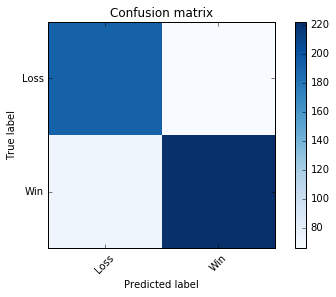

Loss Acc: 0.744186046512
Win Acc: 0.752542372881
Avg Acc: 0.748364209696


In [12]:
p = {'n_estimators':[10, 50, 100], 'max_features': ['sqrt']}
m_RF, param_RF = fit_best_model(ExtraTreesClassifier, p)

print('Random Forest Parameters:', param_RF)
run_model(m_RF)

In [13]:
predictions = m_RF.predict_proba(submission_test)
Submission.Pred = predictions[:,1]
ExtremelyRandomForestSubmission = Submission[['Id','Pred']].sort_values(by = 'Id')
ExtremelyRandomForestSubmission.to_csv("results1/submissionExtraRF.csv",index = False)

# Naive Bayes

[[187  71]
 [ 64 231]]


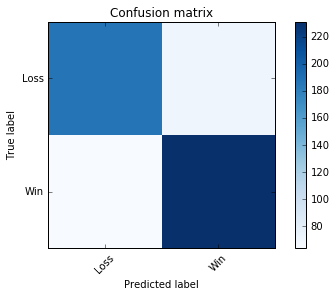

Loss Acc: 0.72480620155
Win Acc: 0.783050847458
Avg Acc: 0.753928524504


In [14]:
clf3.fit(X, y)
run_model(clf3)

In [15]:
predictions = clf3.predict_proba(submission_test)
Submission.Pred = predictions[:,1]
NaiveBayesSubmission = Submission[['Id','Pred']].sort_values(by = 'Id')
NaiveBayesSubmission.to_csv("results1/submissionNB.csv",index = False)

# Voting Classifier Ensemble

[[202  56]
 [ 59 236]]


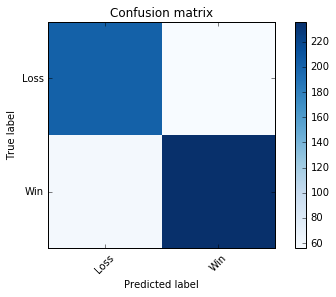

Loss Acc: 0.782945736434
Win Acc: 0.8
Avg Acc: 0.791472868217
('Voting Classifier Parameters:', {'voting': 'hard', 'weights': [0.99, 0.05, 0.05]})


In [16]:
param_eclf = {'voting':['soft','hard'], 'weights': [[.99,.05,.05],[.79,.75,.79]]}
eclf, param_eclf = fit_best_voting_model(VotingClassifier, param_eclf)
run_model(eclf)
print('Voting Classifier Parameters:', param_eclf)

In [17]:
predictions = clf3.predict_proba(submission_test)
Submission.Pred = predictions[:,1]
EnsembleSubmission = Submission[['Id','Pred']].sort_values(by = 'Id')
EnsembleSubmission.to_csv("results1/submissionVoting.csv",index = False)

# Gradient Boost

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
param_gclf = {
    'n_estimators':[10, 16, 32, 50, 100, 500, 1000], 
    'learning_rate':[0.01, 0.8, 1]
}

gclf = GradientBoostingClassifier()
grid = GridSearchCV(gclf, param_gclf)
grid.fit(X, y)
gclf = grid.best_estimator_

In [19]:
print('Best Parameters:', grid.best_params_)
predictions = gclf.predict_proba(submission_test)
Submission.Pred = predictions[:,1]
GradientBoostSubmission = Submission[['Id','Pred']].sort_values(by = 'Id')
GradientBoostSubmission.to_csv("results1/submissionGBC.csv", index=False)

('Best Parameters:', {'n_estimators': 50, 'learning_rate': 0.01})
